# Site Data Manipulation

* Processing and manipulation of site data for the Argus project weekly meetings.
* Data should be in the form of at least 1 csv for GMR data.
* Rework of the original processing script to track individual sensors rather than locations and to include temperature compensation and spike monitoring.

In [1]:
import numpy as np
import pandas as pd
import src.dataIO as io
import src.filepaths as fp
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

root = Path().absolute()
storage = Path('K://Josh/Argus_Project')

site_data = Path(f'{storage}/Site_Data/Sensor_Data')
out_path = Path(f'{storage}/Site_Data/Sensor_Figures')

* Read in all the files in the site data directory as the sensors are individually tagged and have a time date stamp, so the order of the files and file names are irrelevant here.
* Uses a standard function intended to find all files with a given file type.

In [2]:
data_files = fp.extractfile(
    directory_path=site_data,
    file_string='.csv')
print(data_files)

['AmineOxide_Data_240717.csv', 'FFR_Data_240618.csv', 'FFR_Data_240702.csv', 'FFR_Data_240708.csv', 'FFR_Data_240715.csv', 'Hoyer_Data_240708.csv', 'Hoyer_Data_240715.csv', 'L300_Data_240625.csv', 'L300_Data_240702.csv', 'L300_Data_240715.csv', 'L300_Data_240723.csv', 'Libra_Data1_240625.csv', 'Libra_Data2_240625.csv', 'Libra_Data_240618.csv', 'Libra_Data_240715.csv', 'Libra_Data_240724.csv']


* Read all the headers to track individual sensors.
* Note that this only works if the sensor tags are kept consistent at the plant/sensor location/server.
* Headers/tags are used to track the sensors along with the timestamp information.

In [3]:
headers = []
for file in data_files:
    file_path = Path(f'{site_data}/{file}')
    data = pd.read_csv(
        filepath_or_buffer=file_path,
        sep=',')
    data_headers = list(data)
    for header in data_headers:
        if header == 'timestamp':
            pass
        elif header not in headers:
            headers.append(header)
        else:
            pass
print(headers)

['Amine_Oxide_Flow_Sensor_1', 'Amine_Oxide_Flow_Sensor_2', 'MgS04_RM_LHS_Sensor_2_value', 'MgS04_RM_LHS_Sensor_3_value', 'MgS04_RM_RHS_Sensor_2_value', 'MgS04_RM_RHS_Sensor_3_value', 'T200_Sensor_2_value', 'T200_Sensor_3_value', 'T52_Sensor_2_value', 'T52_Sensor_3_value', 'Amine_Oxide_Ring_Main_Tank_Temperature_Transmitter', 'Amine_Oxide_T51_Tank_Level', 'Amine_Oxide_T52_Tank_Level', 'MgS04_RM_LHS_Temp_2_value', 'MgS04_RM_LHS_Temp_3_value', 'MgS04_RM_RHS_Temp_2_value', 'MgS04_RM_RHS_Temp_3_value', 'MgSO4_T200_Tank_Level', 'Auto_meas_procc_dis', 'Auto_meas_procc_period', 'Auto_measure', 'Controller_error_sts', 'External_Power', 'Sensor_2', 'Sensor_2_raw', 'Sensor_3', 'Sensor_3_raw', 'Sensor_4', 'Sensor_4_raw', 'Sensor_data', 'Temperature_2', 'Temperature_3', 'Temperature_4', 'Temperature_External', 'L300_Sensor_1_value', 'L300_Sensor_2_value', 'L300_Tank_Level', 'L300_Temp_1_value', 'L300_Temp_2_value', 'Coloured_Reblend_L300_Sensor_1_value', 'Coloured_Reblend_L300_Sensor_2_value', 'Lin

* Introduce function to parse the time stamps from the different server outputs.
* Some are in a different format, which is helpful but not an issue with this function.
* Add the timestamp formats to the top if statement if further issues arise.
* Function has been moved to src.dataIO.
* Set time 0 to be the start of the data transfer period.
* First batch of data began at 6am on the 11th June 2024.

In [4]:
t_0 = '11/06/2024 06:00'
t_0_object = io.parse_date(date_string=t_0)
t0 = io.convert_datetime(date_time=t_0_object)
print(t0)

1718082000.0


* Start by simply plotting the data that comes from the Argus server.
* Simple plotting of the sensor data from time t0.

In [5]:
for index, header in enumerate(headers):
    x_data = []
    y_data = []
    for file in data_files:
        file_path = Path(f'{site_data}/{file}')
        data = pd.read_csv(
            filepath_or_buffer=file_path,
            sep=',')
        data_headers = list(data)
        if header in data_headers:
            x_data.extend(data['timestamp'])
            y_data.extend(data[f'{header}'])
    time_objects = [io.parse_date(date_string=string) for string in x_data]
    time = [io.convert_datetime(date_time=time) for time in time_objects]
    zipped_lists = zip(time, y_data)
    sorted_pairs = sorted(zipped_lists)
    tuples = zip(*sorted_pairs)
    sorted_time, sorted_y = [list(tuple) for tuple in tuples]
    time_seconds = [io.zeros_times(time=t, t_0=t0) for t in sorted_time]
    time_hours = [t / 3600 for t in time_seconds]
    time_days = [t / 24 for t in time_hours]

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=[15 * 0.393701, 9 * 0.393701],
        dpi=600)
    ax.scatter(
        time_days,
        sorted_y,
        color=f'C{index}',
        s=2,
        label=f'{header}')
    ax.set_title(
        f'{header}',
        fontweight='bold',
        fontsize=6)
    ax.set_xlabel(
        f'Time [Days]',
        fontweight='bold',
        fontsize=8)
    ax.grid(
        True,
        alpha=0.5)
    ax.tick_params(
        axis='both',
        labelsize=6)
    ax.set_xlim(0, max(time_days))
    ax.xaxis.set_major_locator(MultipleLocator(7))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    fig.tight_layout()
    plt.savefig(
        Path(f'{out_path}/{header}.png'),
        bbox_inches='tight')
    plt.clf()
    plt.close(fig)

* General plots sorted.
* Now correct for temperature fluctuations using the same technique as with the temperature compensation script.
* Let's start with a sensor that isn't a condensate sensor, i.e., something that should be easier to figure out.
* Amine Oxide Flow Sensor 1 seems to be uncorrected in any way and there is plenty of data there to look at, so let's look at that one.

## Temperature Compensation

* Start by loading the data in properly.

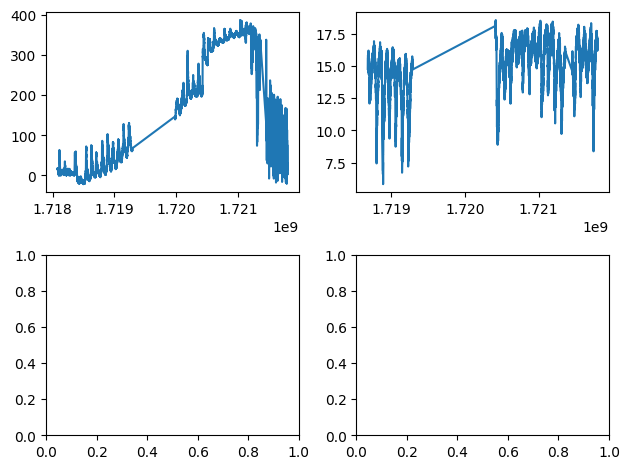

In [6]:
header = 'Amine_Oxide_Flow_Sensor_1'
temperature = 'Amine_Oxide_Flow_Temp_1'

sensor_data = []
sensor_time = []
temperature_data = []
temperature_time = []

for file in data_files:
    file_path = Path(f'{site_data}/{file}')
    data = pd.read_csv(
        filepath_or_buffer=file_path,
        sep=',')
    data_headers = list(data)
    if header in data_headers:
        sensor_time.extend(data['timestamp'])
        sensor_data.extend(data[f'{header}'])
for file in data_files:
    file_path = Path(f'{site_data}/{file}')
    data = pd.read_csv(
        filepath_or_buffer=file_path,
        sep=',')
    data_headers = list(data)
    if temperature in data_headers:
        temperature_time.extend(data['timestamp'])
        temperature_data.extend(data[f'{temperature}'])

sensor_objects = [io.parse_date(date_string=string) for string in sensor_time]
sensor_times = [io.convert_datetime(date_time=time) for time in sensor_objects]
zipped_lists = zip(sensor_times, sensor_data)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
sensor_time, sensor_data = [list(tuple) for tuple in tuples]

temperature_objects = [io.parse_date(date_string=string) for string in temperature_time]
temperature_times = [io.convert_datetime(date_time=time) for time in temperature_objects]
zipped_lists = zip(temperature_times, temperature_data)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
temperature_time, temperature_data = [list(tuple) for tuple in tuples]



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.plot(sensor_time, sensor_data)
ax2.plot(temperature_time, temperature_data)
#ax3.plot(sensor_data, temperature_data)
fig.tight_layout()
plt.show()

* That doesn't work, instead try make sure that the time frames are the same.

In [7]:
joint_time = []
joint_sensor = []
joint_temperature = []

for i, time in enumerate(sensor_time):
    for j, temp_time in enumerate(temperature_time):
        if time == temp_time:
            joint_time.append(time)
            joint_sensor.append(sensor_data[i])
            joint_temperature.append(temperature_data[j])

print(len(joint_sensor))
print(len(joint_temperature))

97919
97919


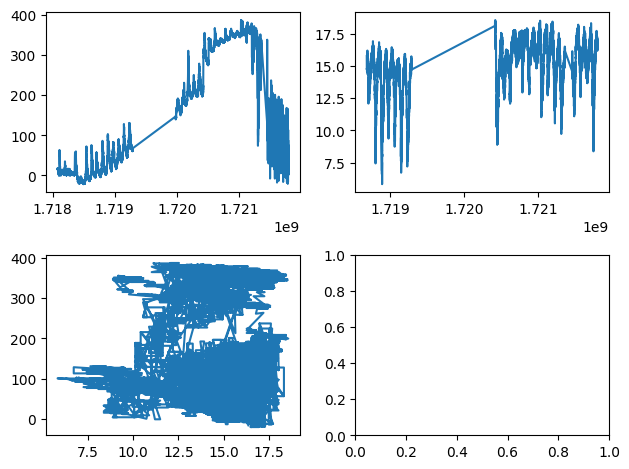

In [8]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.plot(sensor_time, sensor_data)
ax2.plot(temperature_time, temperature_data)
ax3.plot(joint_temperature, joint_sensor)
fig.tight_layout()
plt.show()

[ 20.71371465 -58.72091431]
 
20.71 x - 58.72


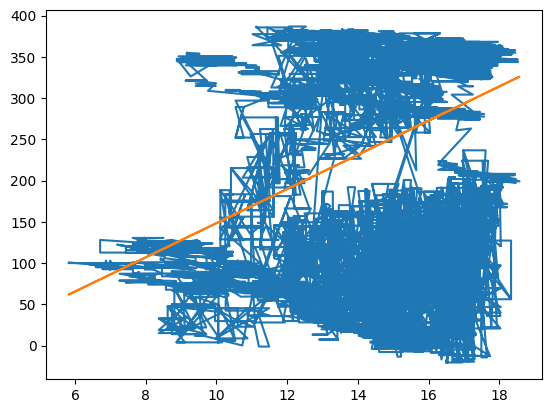

In [9]:
degree = 1

coefficients = np.polyfit(joint_temperature, joint_sensor, degree)
polynomial = np.poly1d(coefficients)

print(coefficients)
print(polynomial)

fig, ax = plt.subplots()
ax.plot(joint_temperature, joint_sensor)
ax.plot(joint_temperature, polynomial(joint_temperature))
plt.show()

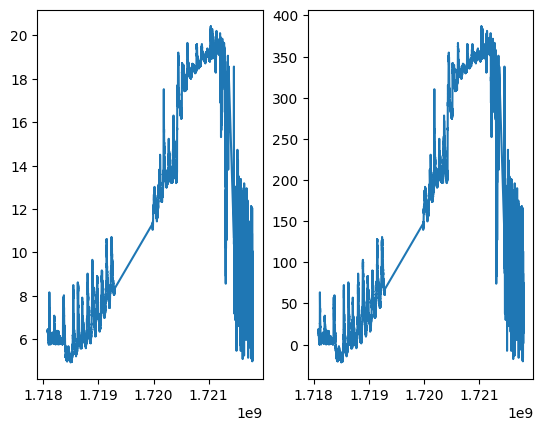

In [10]:
new_sensor_data = [(y + 152.1) / 26.4 for y in sensor_data]

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(sensor_time, new_sensor_data)
ax2.plot(sensor_time, sensor_data)
plt.show()

## Symmetrical Sensor Matching

* Some of the Sensors look very similar.
* So let's plot them as subtractions and see if there are any errors.